# Normalizing Flows

In this notebook we implement some simple normalizing flows to learn univariate distributions.
First, the necessary imports.

In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch

from src.utils.plotting import init_plot_style

init_plot_style()

Let's define our ground truth distribution as a mixture of Gaussians.

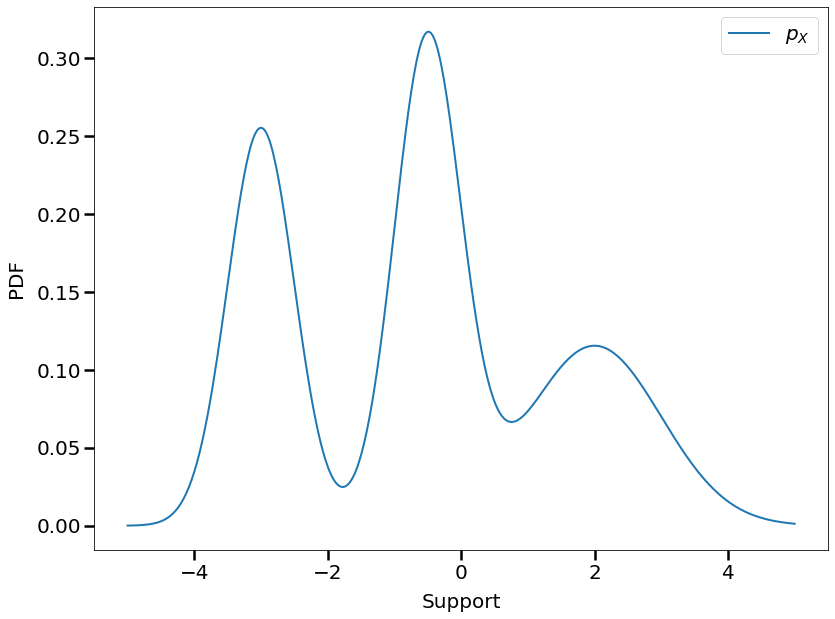

In [2]:
# define ground truth distribution
locs = torch.tensor([-3.0, -0.5, 2.0]).view(-1,1)
covs = torch.tensor([0.5, 0.5, 1.0]).view(-1,1)
weights = torch.tensor([0.3, 0.5, 0.2])
px = dist.MixtureOfDiagNormals(locs, covs, weights)

# sample distribution over support
support = torch.linspace(-5, 5, 500).view(-1,1)
pdf = torch.exp(px.log_prob(support))

# plot the pdf
plt.close('all')
plt.figure()
plt.plot(support, pdf, label=r'$p_X$')
plt.xlabel('Support')
plt.ylabel('PDF')
plt.legend()
plt.tight_layout()

Now let's construct a spline coupling flow.

In [3]:
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
num_components = 2
transforms = [dist.transforms.spline(1, count_bins=32, bound=20) for _ in range(num_components)]
qx = dist.TransformedDistribution(base_dist, transforms)

We are ready to train our flow!

In [4]:
# sample training data from the true distribution
num_samples = 5000
data = px.sample(torch.Size([num_samples,])).detach()

# configure optimizier
modules = torch.nn.ModuleList(transforms)
optimizer = torch.optim.Adam(modules.parameters(), lr=5e-2)

# start training
steps = 500
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -qx.log_prob(data).mean()
    loss.backward()
    optimizer.step()
    qx.clear_cache()

    if step % 100 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 11.488995552062988
step: 100, loss: 1.9582183361053467
step: 200, loss: 1.9420493841171265
step: 300, loss: 1.9391484260559082
step: 400, loss: 1.938016653060913
step: 500, loss: 1.9371141195297241


Let's see what we have learned.

In [ ]:
# sample distribution over support
support = torch.linspace(-5, 5, 500).view(-1,1)
pdf_approx = torch.exp(qx.log_prob(support)).detach()

# plot the pdf
plt.close('all')
plt.figure()
plt.plot(support, pdf, label=r'$p_X$')
plt.plot(support, pdf_approx, label=r'$q_X$')
plt.xlabel('Support')
plt.ylabel('PDF')
plt.legend()
plt.tight_layout()